In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

Collect the spatial units:

In [2]:
#MODZCTA shapefile:
modzcta_gdf = gpd.read_file('data/ModZCTA.geojson')[['modzcta', 'pop_est', 'geometry']].set_index('modzcta').rename({'pop_est':'Population'},axis=1)
modzcta_gdf.index = modzcta_gdf.index.astype(int)

#ZCTA to MODZCTA crosswalk:
crosswalk = pd.read_excel('data/ModZCTA_crosswalk.xlsx', sheet_name='ZCTA to MODZCTA (crosswalk)')[['ZCTA', 'MODZCTA', 'UHFNAME']].set_index('ZCTA')
crosswalk.index = crosswalk.index.astype(int)

ERROR 1: PROJ: proj_create_from_database: Open of /home/gs665/.conda/envs/mapping/share/proj failed


Boundary:

In [3]:
boundary_gdf = gpd.read_file('data/boundaries/nybb.shp').to_crs(modzcta_gdf.crs).dissolve()

Collect the dog data:

In [4]:
#Raw data:
all_dog_data = pd.read_csv('data/dog_data.csv', low_memory=False)

#Map to ModZCTA:
all_dog_data['ZipCode'] = pd.to_numeric(all_dog_data['ZipCode'], errors='coerce').replace({np.nan:99999}).astype(int)
all_dog_data['MODZCTA'] = all_dog_data['ZipCode'].map(crosswalk['MODZCTA'].to_dict())

#Get current extract year:
dog_data_2024 = all_dog_data[all_dog_data['Extract Year'] == 2024].reset_index(drop=True)

#Count dogs by MODZCTA:
dog_counts = dog_data_2024.groupby('MODZCTA').size()
dog_counts.index = dog_counts.index.astype(int)
modzcta_gdf['dog_count'] = dog_counts
modzcta_gdf.dropna(inplace=True)

Generate dogs:

In [5]:
#Generate random points within each MODZCTA polygon according to dog counts:
dots = modzcta_gdf['geometry'].sample_points(size=modzcta_gdf['dog_count'].values.astype(int))

Map:

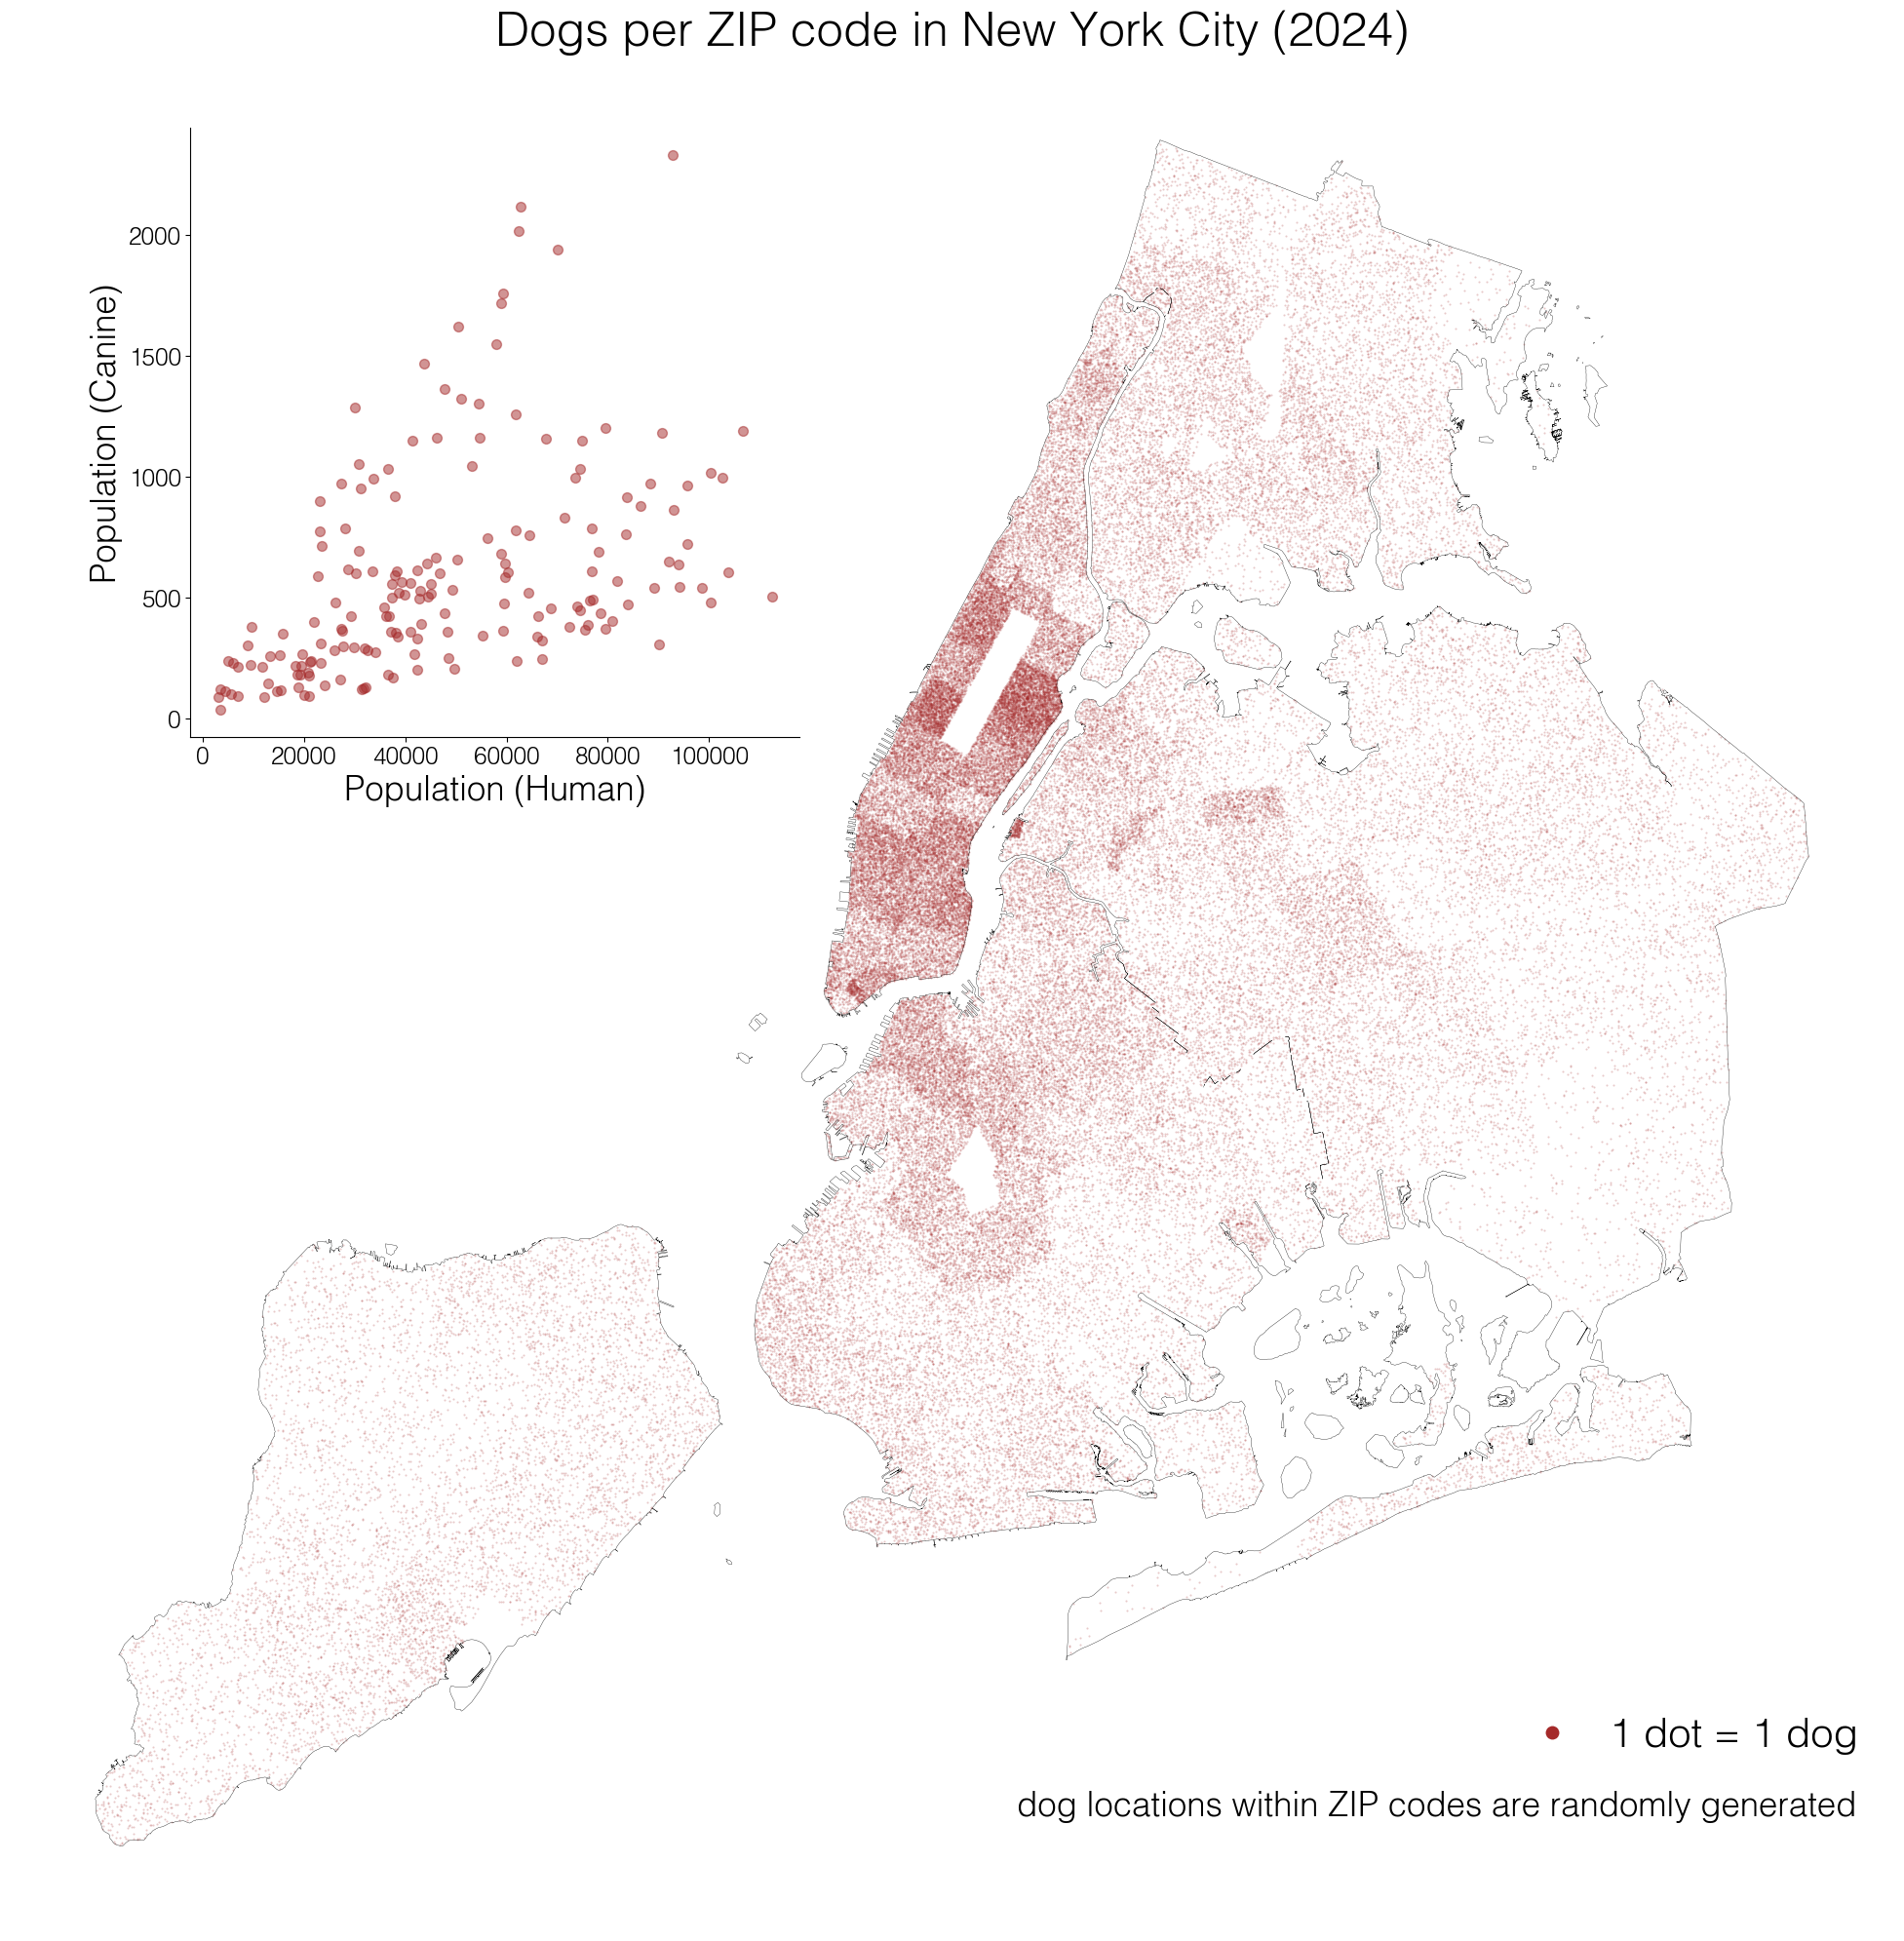

In [13]:
fig, ax = plt.subplots(figsize=(25,25))

#Make the map:
_ = dots.plot(markersize=.25, color='brown', alpha=.25, ax=ax)
_ = boundary_gdf.boundary.plot(linewidth=.25, color='k',ax=ax)

#Make the inset:
inset_ax = fig.add_axes([0.2, 0.6, 0.25, 0.25])  # [left, bottom, width, height] in figure coords
_ = inset_ax.scatter(x=modzcta_gdf['Population'].astype(int), y=modzcta_gdf['dog_count'].astype(int), color='brown', alpha=0.5, s=50)
_ = inset_ax.set_xlabel("Population (Human)", fontsize=25)
_ = inset_ax.set_ylabel("Population (Canine)", fontsize=25)
_ = inset_ax.tick_params(labelsize=17.5)
_ = inset_ax.spines[['right', 'top']].set_visible(False)

#Legend 1 dot = 1 dog i.e. has to have a brown dot and say 1 dog:
legend_dot = Line2D([0], [0], marker='o', color='none', markerfacecolor='brown', markeredgecolor='none', markersize=10, label='1 dot = 1 dog')
_ = ax.legend(handles=[legend_dot], frameon=False, fontsize=30,
    handletextpad=0.4,
    loc='lower right',
    bbox_to_anchor=(1., 0.075),  # (x, y) in axes coords (0–1)
    bbox_transform=ax.transAxes
)

#Annotate:
_ = ax.text(.98, 0.075, 'dog locations within ZIP codes are randomly generated', 
    fontsize=25, color='k',
    ha='right', va='top',
    transform=ax.transAxes
)

#Configure:
_ = ax.set_title('Dogs per ZIP code in New York City (2024)', fontsize=35)
_ = ax.axis('off')

plt.savefig('../map.png', dpi=300, bbox_inches='tight')
plt.savefig('../map.pdf', dpi=300, bbox_inches='tight')